# ToDo

Next week: OpenCV, CNN, doc, M5 day; HOML night


4. Join other data
10. Regularize
1. Try SVM's 
1. Try polynomial features
1. Sratified KFolds
1. Cross validation
1. Same scales broader boundaries
2. Feature Importance 
3. Pipelines
4. Put into functions


References
1. [Dermatologist skin cancer classification CNN](https://towardsdatascience.com/dermatologist-level-skin-cancer-classification-using-neural-network-475f93d7f8c3)
2. [Painting and Sketching with OpenCV](https://towardsdatascience.com/painting-and-sketching-with-opencv-in-python-4293026d78b)
2. [Data Visualization in Python with fully-interactive plots Python](https://towardsdatascience.com/the-next-level-of-data-visualization-in-python-dd6e99039d5e)
2. [how to implement a lightgbm](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)
2. [Cat Dog classifier CNN](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)
2. [feature importance with xgboost](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)
2. [shapley-values](https://medium.com/@santiagof/model-interpretability-making-your-model-confess-shapley-values-5fb95a10a624)
2. [Find and Draw Contours using OpenCV](https://www.geeksforgeeks.org/find-and-draw-contours-using-opencv-python/)
2. [Medical Image Segmentation [Part 1] — UNet: Convolutional Networks with Interactive Code](https://medium.com/@SeoJaeDuk/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-d07231eb29bf)
2. [Complexity - Morphometrics](https://www.researchgate.net/post/Can_anyone_give_me_information_about_Perimeter_Area_relationship_and_its_importance_mathematically_and_biometrically_plant_leaves_phenomics)

**Idea**: Add computed features using time windows on each image generating interactions  image_count(add) and anatom_site categories 

**Summary:** To train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores. 


In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from IPython import display
import seaborn as sns
sns.set()
import matplotlib
from pylab import rcParams
import itertools 
import time 
from random import seed
from random import random
from matplotlib import pyplot

#from skimage.io import imread
from PIL import Image

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#Reading data, calendar and sell_prices
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
train.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0


# Models to try
### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Function for comparing different approaches
def train_randomForest(X_train, X_valid, y_train, y_valid, test = None, feature_cols=None, plott = False):
    if feature_cols is None:
        feature_cols = X_train.columns
    model = RandomForestClassifier(n_estimators=20, random_state=42)
    model.fit(X_train[feature_cols], y_train)
    preds = model.predict_proba(X_valid[feature_cols])[:,1]
    valid_score = metrics.roc_auc_score(y_valid, preds)
    if plott:
        fpr, tpr, _ = metrics.roc_curve(y_valid, preds, pos_label=None)
        plt.scatter(fpr,tpr)
        plt.plot(fpr,fpr)
        plt.xlabel('false positives rate')
        plt.ylabel('true positives rate')
    print(f"random forest AUC score: {valid_score}")
    return valid_score
    if test is not None: 
        test_pred = model.predict(test)
        return model, valid_score, test_pred
    else:
        return model, valid_score

### Light Gradient Boosted Machine (lightGBM)

In [18]:
import lightgbm as lgb

def train_lbgm(train, valid, y_train, y_valid, test=None, feature_cols=None, plott=False, num_leaves = 16):
    if feature_cols is None:
        feature_cols = train.columns
    dtrain = lgb.Dataset(train[feature_cols], label=y_train)
    dvalid = lgb.Dataset(valid[feature_cols], label=y_valid)
    
    param = {'num_leaves': num_leaves, 'objective': 'binary', 'metric': 'auc', 'seed': 42}
    num_round = 20000
    print("Training model. Hold on a minute to see the validation score")
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=40, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(y_valid, valid_pred)
    print(f"lightbgm AUC score: {valid_score}")
    if plott:
        fpr, tpr, _ = metrics.roc_curve(y_valid, valid_pred, pos_label=1)
        plt.scatter(fpr,tpr)
        plt.plot(fpr,fpr)
        plt.xlabel('false positives rate')
        plt.ylabel('true positives rate')
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        return bst, valid_score, test_pred
    else:
        return bst, valid_score

### Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression

def train_logisticReg(X_train, X_valid, y_train, y_valid, test = None, feature_cols=None, plott = False):
    if feature_cols is None:
        feature_cols = X_train.columns
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train[feature_cols], y_train)
    preds = clf.predict_proba(X_valid[feature_cols])[:,1]
    valid_score = metrics.roc_auc_score(y_valid, preds)
    if plott:
        fpr, tpr, _ = metrics.roc_curve(y_valid, preds, pos_label=None)
        plt.scatter(fpr,tpr)
        plt.plot(fpr,fpr)
        plt.xlabel('false positives rate')
        plt.ylabel('true positives rate')
    print(f"Logistic Regression AUC score: {valid_score}")
    if test is not None: 
        test_pred = clf.predict(test)
        return clf, valid_score, test_pred
    else:
        return clf, valid_score

### XGBOOST

In [226]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

def train_xgb(train, valid, y_train, y_valid, test=None, feature_cols=None, plott=False, 
              num_round = 200,eta = 0.4, alpha=0.0, gamma=0.0, max_depth = 8):
    if feature_cols is None:
        feature_cols = train.columns
    dtrain = xgb.DMatrix(train[feature_cols], label=y_train)
    dvalid = xgb.DMatrix(valid[feature_cols], label=y_valid)
    #param = {'num_leaves': num_leaves, 'objective': 'binary', 'metric': 'auc', 'seed': 42
    param = {'eta': eta,'alpha':alpha, 'max_depth':max_depth, 'objective': 'multi:softprob', 'gamma': gamma,'num_class': 2} 
    
    print("Training model.")
    bst = xgb.train(param, dtrain, num_round, evals=[(dvalid, "valid")], early_stopping_rounds=20, verbose_eval=False)
    
    valid_pred = bst.predict(dvalid)
    valid_score = metrics.roc_auc_score(y_valid, valid_pred[:,1])
    print(f"XGBoost AUC score: {valid_score}")
    if plott:
        fpr, tpr, _ = metrics.roc_curve(y_valid, valid_pred[:,1], pos_label=None)#, pos_label=1)
        plt.scatter(fpr,tpr)
        plt.plot(fpr,fpr)
        plt.xlabel('false positives rate')
        plt.ylabel('true positives rate')
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        return bst, valid_score, test_pred
    else:
        return bst, valid_score



In [317]:
eta = 0.4
max_depth = 6
D_train = xgb.DMatrix(baseline_train, label = y_train)
D_val = xgb.DMatrix(baseline_valid, label = y_valid)
param = {'eta': eta,'alpha':0.1, #'delta':0.1,
         'max_depth':max_depth, 'objective': 'multi:softprob', 'gamma': 0.00,'num_class': 2} 
steps = 21  # The number of training iterations
model = xgb.train(param, D_train, steps)

preds = model.predict(D_val)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, preds[:,1], pos_label=None)
#plt.scatter(fpr,tpr)
#plt.plot(fpr,fpr)
#plt.xlabel('false positives rate')
#plt.ylabel('true positives rate')

### Extract gender per patient

In [5]:
def create_patient_df(train,test):
    #Create a series with patient_id as index and gender values for train and test
    patient_gender_train = train.groupby("patient_id").sex.unique().apply(lambda l: l[0])
    patient_gender_test = test.groupby("patient_id").sex.unique().apply(lambda l: l[0])
    #Convert series into train_patients and test_patients dataframes 
    train_patients = pd.DataFrame(index=patient_gender_train.index.values, 
                                  data=patient_gender_train.values, columns=["sex"])
    test_patients = pd.DataFrame(index=patient_gender_test.index.values, 
                                 data=patient_gender_test.values, columns=["sex"])
    #Extract nun_images with proper groupby
    train_patients["num_images"] = train.groupby("patient_id").size()
    test_patients["num_images"] = test.groupby("patient_id").size()
    #Extract age_span for patient with multiple images
    train_patients["min_age"] = train.groupby("patient_id").age_approx.min()
    train_patients["max_age"] = train.groupby("patient_id").age_approx.max()
    test_patients["min_age"] = test.groupby("patient_id").age_approx.min()
    test_patients["max_age"] = test.groupby("patient_id").age_approx.max()
    train_patients["age_span"] = train_patients["max_age"] - train_patients["min_age"]
    test_patients["age_span"] = test_patients["max_age"] - test_patients["min_age"]
    #Extract benign_cases  and min and max aged for malignant
    train_patients["benign_cases"] = train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "benign"]
    train_patients["malignant_cases"] = train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "malignant"]
    train_patients["min_age_malignant"] = train.groupby(["patient_id", "benign_malignant"]).age_approx.min().loc[:, "malignant"]
    train_patients["max_age_malignant"] = train.groupby(["patient_id", "benign_malignant"]).age_approx.max().loc[:, "malignant"]
    return train_patients, test_patients


## Patient Id Counts

In [6]:
train_patients, test_patients = create_patient_df(train,test)
print("train_patients shape:",train_patients.shape)
print('Malignant cases count train:')
print(train_patients.malignant_cases.notnull().value_counts())
train_patients.sort_values(by="malignant_cases", ascending=False).head(2)

train_patients shape: (2056, 9)
Malignant cases count train:
False    1628
True      428
Name: malignant_cases, dtype: int64


,sex,num_images,min_age,max_age,age_span,benign_cases,malignant_cases,min_age_malignant,max_age_malignant
IP_7373371,female,42,55.0,60.0,5.0,34.0,8.0,55.0,60.0
IP_9111321,male,13,60.0,60.0,0.0,7.0,6.0,60.0,60.0


## Preprocess Categorical Variables

##  Impute and label encode separately for the test-valid-train distributions

Better suited for production like scenarios.

Missing values and `SimpleImputer`. The `anatom_site_general_challenge` and sex` category` in the train set has a lot of  NaNs, we will repalce them with the `'Unknown'` (try `.mode()`).  Is this the best approach ??

/Users/felipevallejomonsalve/opt/anaconda3/envs/dataScience/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Labeled and imputed features:
Logistic Regression AUC score: 0.7561339888652556
random forest AUC score: 0.6678735117836899
Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8193574340755204
feature_importance: [12 24 63 20 24 26 26]
Training model.
XGBoost AUC score: 0.7724893553548666


,sex,anatom_site_general_challenge,num_images,age_approx,min_age,max_age,age_span
22826,1,2,32.0,40.0,35.0,40.0,5.0


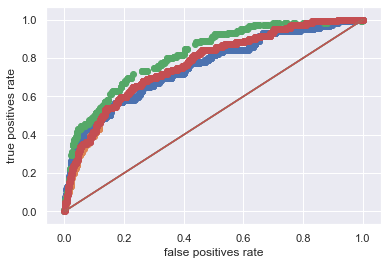

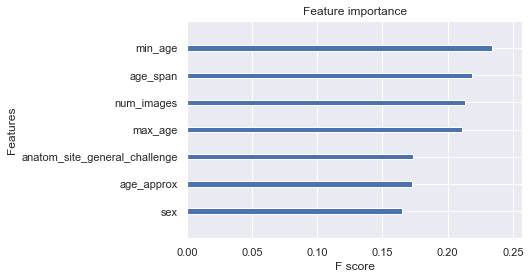

In [319]:
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# target
cols_to_drop = ['image_name','diagnosis', 'benign_malignant','target']
y = train.target
X = train.drop(cols_to_drop, axis=1)

#Missing values Categorcial values train
# Fill NaN with Unknown on anatom_site_general_challenge
mode1 = X['anatom_site_general_challenge'].mode()[0]
X['anatom_site_general_challenge'].fillna('Unknown', inplace=True)
# Fill NaN with mode on 'sex'
mode = X['sex'].mode()[0]
X['sex'].fillna('Unknown', inplace=True)

#Add patient df to train set
train_patients_cols_add=["num_images","min_age","max_age","age_span"]
X =X.reset_index().merge(train_patients[train_patients_cols_add].reset_index().rename(columns={'index':"patient_id"}), 
                         on =["patient_id"]).sort_values(by='index').set_index('index').reset_index(drop=True)

#Add patient test set
X_test=test.reset_index().merge(test_patients[train_patients_cols_add].reset_index().rename(columns={'index':"patient_id"}), 
                                on =["patient_id"]).sort_values(by='index').set_index('index').reset_index(drop=True)


# Fill NaN with Unknown on anatom_site_general_challenge
X_test['anatom_site_general_challenge'].fillna('Unknown', inplace=True)



# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=42)
# All categorical columns
object_cols = ['patient_id', 'sex', 'anatom_site_general_challenge']

# Imputation Numerical features 
# Get names of columns with missing values
cols_with_missing = ['num_images','age_approx', 'min_age','max_age','age_span']
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[cols_with_missing]), index=X_train.index)
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[cols_with_missing]), index=X_valid.index)


# Imputation removed column names; put them back
imputed_X_train.columns = X_train[cols_with_missing].columns
imputed_X_valid.columns = X_valid[cols_with_missing].columns

# Columns that can be safely label encoded and Problematic columns
label_cols = ['sex', 'anatom_site_general_challenge']
not_label_cols = ['patient_id', 'age_approx', 'min_age','max_age','age_span','num_images']
# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(not_label_cols, axis=1)
label_X_valid = X_valid.drop(not_label_cols, axis=1)
label_X_test  = X_test[label_cols]
# Apply label encoder to bad_label_cols 
label_encoder = preprocessing.LabelEncoder()
for col in label_cols:
    label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
    label_X_valid[col] = label_encoder.transform(label_X_valid[col])    
    label_X_test[col] = label_encoder.transform(label_X_test[col])    
#Create baseline data
baseline_train = label_X_train.join(imputed_X_train)
baseline_valid = label_X_valid.join(imputed_X_valid)
baseline_test = label_X_test.join(X_test[cols_with_missing])
# Compute models
print("Labeled and imputed features:")
lgstc, _ =train_logisticReg(baseline_train, baseline_valid, y_train, y_valid, plott=True)
train_randomForest(baseline_train, baseline_valid, y_train, y_valid, plott=True)
bst, _ = train_lbgm(baseline_train, baseline_valid, y_train, y_valid, plott=True, 
                    num_leaves =16)
print("feature_importance:",bst.feature_importance())
xgbst, _ =train_xgb(baseline_train, baseline_valid, y_train, y_valid, plott=True,
         num_round = 200,eta = 0.4, alpha=0.0, gamma=0.0, max_depth = 16)
plot_importance( xgbst, importance_type='gain', show_values=False)
baseline_train.head(1)

#### Submission baseline results:

In [313]:
#xgboost
d_test = xgb.DMatrix(baseline_test)
sample_submission['target'] = xgbst.predict(d_test)[:,1]
sample_submission.to_csv("../data/submission_v11.csv", index=False)
sample_submission.head()

,image_name,target
0,ISIC_0052060,0.000772
1,ISIC_0052349,0.000212
2,ISIC_0058510,0.002538
3,ISIC_0073313,0.000310
4,ISIC_0073502,0.091666


In [283]:
#lbgm
sample_submission['target'] = bst.predict(baseline_test)
sample_submission.to_csv("../data/submission_v8.csv", index=False)
sample_submission.head()

,image_name,target
0,ISIC_0052060,0.006712
1,ISIC_0052349,0.006308
2,ISIC_0058510,0.009496
3,ISIC_0073313,0.006706
4,ISIC_0073502,0.017783


In [315]:
#logistic regression
sample_submission['target'] = lgstc.predict_proba(baseline_test)[:,1]
sample_submission.to_csv("../data/submission_v12.csv", index=False)
sample_submission.head()

,image_name,target
0,ISIC_0052060,0.000001
1,ISIC_0052349,0.003218
2,ISIC_0058510,0.009063
3,ISIC_0073313,0.004611
4,ISIC_0073502,0.036901


In [294]:
lgstc.predict_proba(baseline_test)[:,1]

array([1.35113632e-06, 3.21778381e-03, 9.06320503e-03, ...,
       1.38888338e-02, 2.41325179e-02, 7.87960348e-03])

In [99]:
print("lbgm Score submission_v6.csv num_leaves 16: 0.6433") 

lbgm Score submission_v6.csv num_leaves 16: 0.6433


In [104]:
print("lbgm Score submission_v7.csv num_leaves 64: 0.6341") 

lbgm Score submission_v7.csv num_leaves 64: 0.6341


In [259]:
print("lbgm Score submission_v8.csv num_leaves 8: 0.6129") 

lbgm Score submission_v8.csv num_leaves 8: 0.6129


In [311]:
print("XGBoost Score submission_v9.csv (eta = 0.1, alpha=0.1, gamma=0.4, max_depth = 8): 0.6389, valid:0.81409")

XGBoost Score submission_v9.csv (eta = 0.1, alpha=0.1, gamma=0.4, max_depth = 8): 0.6389, valid:0.81409


In [310]:
print("XGBoost Score submission_v10.csv (eta = 0.4, alpha=0.1, gamma=0.2, max_depth = 4): 0.6182 valid:0.81077")

XGBoost Score submission_v10.csv (eta = 0.4, alpha=0.1, gamma=0.2, max_depth = 4): 0.6182 valid:0.81077


In [314]:
print("XGBoost Score submission_v11.csv (eta = 0.4, alpha=0.1, gamma=0.2, max_depth = 4): 0.6058 valid:0.7867655")


XGBoost Score submission_v11.csv (eta = 0.4, alpha=0.1, gamma=0.2, max_depth = 4): 0.6058 valid:0.7867655


This is slighty less than when the encoding is use with pandas `factorize()`. Let's try using only the patient

### Just patient

Logistic Regression AUC score: 0.749636138457227
random forest AUC score: 0.7258711691223284
Training model.
XGBoost AUC score: 0.7688074768865591
Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8105111108528245
feature_importance: [82 42 40 31]


,num_images,min_age,max_age,age_span
22826,32,35.0,40.0,5.0
20292,7,55.0,60.0,5.0


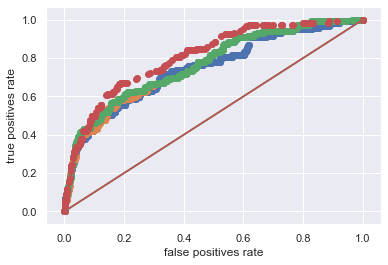

In [222]:
feature_cols = ["num_images", "min_age", "max_age", "age_span"]
train_logisticReg(imputed_X_train, imputed_X_valid, y_train, y_valid,plott=True, feature_cols =feature_cols )
train_randomForest(imputed_X_train, imputed_X_valid, y_train, y_valid,plott=True, feature_cols =feature_cols )
train_xgb(imputed_X_train, imputed_X_valid, y_train, y_valid,plott=True, feature_cols =feature_cols )
bst, _ = train_lbgm(imputed_X_train, imputed_X_valid, y_train, y_valid,plott=True, feature_cols =feature_cols, num_leaves =16 )
print("feature_importance:",bst.feature_importance())
X_train[feature_cols].head(2)

#### Submission patient - lbgm

In [92]:
sample_submission['target'] = bst.predict(X_test[feature_cols].astype(int))
sample_submission.to_csv("../data/submission_v5.csv", index=False)
sample_submission.head()

,image_name,target
0,ISIC_0052060,0.005746
1,ISIC_0052349,0.005232
2,ISIC_0058510,0.009607
3,ISIC_0073313,0.006233
4,ISIC_0073502,0.017541


In [98]:
print("Score submission_v5.csv: 0.6336")

Score submission_v5.csv: 0.6336


### One hot enconding

In [318]:
 # Apply one-hot encoder to each column with categorical data
label_cols = ['sex', 'anatom_site_general_challenge']
OH_encoder = preprocessing.OneHotEncoder( sparse=False)
OH_X_train = pd.DataFrame(OH_encoder.fit_transform(X_train[label_cols]))
OH_X_valid = pd.DataFrame(OH_encoder.transform(X_valid[label_cols]))
# One-hot encoding removed index; put it back
OH_X_train.index = X_train.index
OH_X_valid.index = X_valid.index
#add column names
oh_cols = []
for col in label_cols:
    for index in range(len(X_train[col].value_counts().index)):  
        oh_cols.append(col+'_'+str(index)) 
OH_X_train.columns = oh_cols
OH_X_valid.columns = oh_cols

train_logisticReg(OH_X_train, OH_X_valid, y_train, y_valid,plott=False)
train_randomForest(OH_X_train, OH_X_valid, y_train, y_valid,plott=False)
train_lbgm(OH_X_train, OH_X_valid, y_train, y_valid,plott=False,feature_cols=OH_X_train.columns)
xgbst, _ =train_xgb(OH_X_train, OH_X_valid, y_train, y_valid, plott=False,
         num_round = 200,eta = 0.4, alpha=0.0, gamma=0.0, max_depth = 8)
#plot_importance( xgbst, importance_type='gain', show_values=False)
OH_X_train.head(1)

Logistic Regression AUC score: 0.6044376256726758
random forest AUC score: 0.6007686615448391
Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.6014169614364879
Training model.
XGBoost AUC score: 0.6013730526788862


,sex_0,sex_1,sex_2,anatom_site_general_challenge_0,anatom_site_general_challenge_1,anatom_site_general_challenge_2,anatom_site_general_challenge_3,anatom_site_general_challenge_4,anatom_site_general_challenge_5,anatom_site_general_challenge_6
22826,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Compare with just lable encode alone

In [321]:
feature_cols = imputed_X_train.join(OH_X_train).columns
baseline_train = imputed_X_train.join(OH_X_train), 
baseline_train =imputed_X_valid.join(OH_X_valid),
train_logisticReg ( 
                   y_train, y_valid,plott=False)
imputed_X_train.join(OH_X_train).head(2)

TypeError: train_logisticReg() missing 2 required positional arguments: 'y_train' and 'y_valid'

In [154]:
bst, _ = train_lbgm(X_train.join(OH_X_train).drop(columns=cols_low_card), 
                   X_valid.join(OH_X_valid).drop(columns=cols_low_card), 
                   y_train, y_valid,plott=False, feature_cols =X_train.join(OH_X_train).drop(columns=cols_low_card).columns )
print("feature_importance:",bst.feature_importance())
X_train.join(OH_X_train).drop(columns=cols_low_card).head(1)

Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8131365962705968
feature_importance: [16 56 21 23 17  0  6  1  3  7  5  1  0  5  4]


,age_approx,num_images,min_age,max_age,age_span,sex_0,sex_1,sex_2,anatom_site_general_challenge_0,anatom_site_general_challenge_1,anatom_site_general_challenge_2,anatom_site_general_challenge_3,anatom_site_general_challenge_4,anatom_site_general_challenge_5,anatom_site_general_challenge_6
22826,40.0,32,35.0,40.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 4. Count Encoding

In [324]:
import category_encoders as ce

label_cols = ['patient_id', 'sex', 'anatom_site_general_challenge']


# Create the count encoder
count_enc = ce.CountEncoder(cols=label_cols)

# Learn encoding from the training set
count_encoded = count_enc.fit(X[label_cols])

# Apply encoding to the train and validation sets as new columns
# Make sure to add `_count` as a suffix to the new columns

count_X_train = count_enc.transform(X_train[label_cols]).add_suffix('_count')
count_X_valid = count_enc.transform(X_valid[label_cols]).add_suffix('_count')
count_X_train.head(3)

,patient_id_count,sex_count,anatom_site_general_challenge_count
22826,32,15981,8417
20292,7,15981,16845
29431,40,15981,4983


In [325]:
print("AUC from (OneHot Encode):")
_ = train_randomForest(count_X_train, count_X_valid, y_train, y_valid )
_ = train_logisticReg(count_X_train, count_X_valid, y_train, y_valid )
_ = train_lbgm(count_X_train, count_X_valid, y_train, y_valid, feature_cols = count_X_train.columns, num_leaves=16 )

AUC from (OneHot Encode):
random forest AUC score: 0.7644650299031553
Logistic Regression AUC score: 0.7136768031325024
Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.7761996453722106


In [181]:
_, _ = train_lbgm(X_train.join(count_X_train).drop(columns=label_cols), 
                   X_valid.join(count_X_valid).drop(columns=label_cols), 
                   y_train, y_valid,plott=False)
X_train.join(count_X_train).drop(columns=cols_low_card).head(1)

Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.7692278386688931


,age_approx,num_images,min_age,max_age,age_span,patient_id_count,sex_count,anatom_site_general_challenge_count
22826,40.0,32,35.0,40.0,5.0,32,15981,8417


### 4.  Add interaction features

Add interaction features for each pair of categorical features (sex, anatom_site_general_challenge ). Iterate through the pairs of features is with `itertools.combinations`. For each new column, join the values as strings with an underscore, so 13 and 47 would become `"13_47"`. Label encode the values.

In [326]:
import itertools

cat_features = ['sex', 'anatom_site_general_challenge']
def create_interactions(train, valid, cat_features): 
    interactions_train = pd.DataFrame(index=train.index)
    interactions_valid = pd.DataFrame(index=valid.index)
    # Iterate through each pair of features, combine them into interaction features
    encoder = preprocessing.LabelEncoder()
    for col1, col2 in itertools.combinations(cat_features,2):
        new_col = col1 +'_'+ col2 
        new_vals = train[col1].map(str) + '_' + train[col2].map(str)
        interactions_train[new_col] = encoder.fit_transform(new_vals)
        new_vals = valid[col1].map(str) + '_' + valid[col2].map(str)
        interactions_valid[new_col] = encoder.transform(new_vals)
    return interactions_train, interactions_valid
interactions_train, interactions_valid = create_interactions(X_train,X_valid, cat_features) 
interactions_train.head(1)

,sex_anatom_site_general_challenge
22826,6


## Generate Baseline data

1. Try all features

In [327]:

#add imputed and categorical label
baseline_train = imputed_X_train.join(label_X_train)
baseline_valid = imputed_X_valid.join(label_X_valid)
#add interactions
baseline_train = baseline_train.join(interactions_train)
baseline_valid = baseline_valid.join(interactions_valid)

#baseline_train.drop(columns= cols_to_keep, inplace=True)
#baseline_valid.drop(columns=cols_to_keep, inplace=True)
print("AUC from Approach 2 (Imputation):")
train_logisticReg(baseline_train, baseline_valid, y_train, y_valid)
train_randomForest(baseline_train, baseline_valid, y_train, y_valid)
bst, _ = train_lbgm(baseline_train, baseline_valid, y_train, y_valid, feature_cols = baseline_train.columns)
print("feature_importance:",bst.feature_importance())
baseline_train.head(3)

AUC from Approach 2 (Imputation):
Logistic Regression AUC score: 0.7561546518100093
random forest AUC score: 0.7050041777891424
Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8200825742929723
feature_importance: [68 26 24 22 25  4 18 23]


,num_images,age_approx,min_age,max_age,age_span,sex,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,32.0,40.0,35.0,40.0,5.0,1,2,6
20292,7.0,60.0,55.0,60.0,5.0,1,5,9
29431,40.0,65.0,65.0,65.0,0.0,1,6,10


2. Try only imputed

2. Try only label columns

Baseline model score
Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8200825742929723
feature_importance: [68 26 24 22 25 18 27]


,num_images,age_approx,min_age,max_age,age_span,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,32,40.0,35.0,40.0,5.0,2,6
20292,7,60.0,55.0,60.0,5.0,5,9
29431,40,65.0,65.0,65.0,0.0,6,10


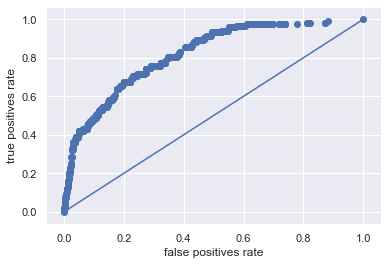

In [200]:
print("Baseline model score")
feature_cols = baseline_train.columns.drop('sex')
bst, _ = train_lbgm(baseline_train, baseline_valid, y_train
                     , y_valid, feature_cols=feature_cols, plott=True)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(3)

In [218]:
feature_cols = [
   'num_images',
  'age_approx',
   'min_age',
  'max_age',
    'age_span',
    'sex',
   'anatom_site_general_challenge',
  'sex_anatom_site_general_challenge'
]
bst, _ = train_lbgm(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(1)

Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8200825742929723
feature_importance: [68 26 24 22 25  4 18 23]


,num_images,age_approx,min_age,max_age,age_span,sex,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,32,40.0,35.0,40.0,5.0,1,2,6


In [211]:
feature_cols = baseline_train.columns.to_list()
bst, _ = train_lbgm(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(3)

Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8200825742929723
feature_importance: [68 26 24 22 25  4 18 23]


,num_images,age_approx,min_age,max_age,age_span,sex,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,32,40.0,35.0,40.0,5.0,1,2,6
20292,7,60.0,55.0,60.0,5.0,1,5,9
29431,40,65.0,65.0,65.0,0.0,1,6,10


## Univariate Feature Selection

The simplest and fastest methods are based on univariate statistical tests. Scikit-learn's feature selection module, `feature_selection.SelectKBest` returns the K best features given some scoring function. For our classification problem, the module provides three different scoring functions: $\chi^2$, ANOVA F-value, and the mutual information score. The F-value measures the linear dependency between the feature variable and the target (might underestimate if nonlinear). The mutual information score is nonparametric and so can capture nonlinear relationships. Using `.fit_transform(features, target)` we get back an array with only the selected features.

In [205]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Keep 5 features
selector = SelectKBest(mutual_info_classif, k=5)
#Use only train set to avoid leakage
X_new = selector.fit_transform(baseline_train, y_train)
selected_features = pd.DataFrame(selector.inverse_transform(X_new),  columns=baseline_train.columns).head()
selected_features = selected_features.columns[selected_features.var() != 0].to_list()
#baseline_train[selected_features].head(2)
selected_features

['num_images', 'age_approx', 'min_age', 'max_age', 'sex']

In [207]:
feature_cols = selected_features
bst, _ = train_lbgm(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(3)

Training model. Hold on a minute to see the validation score
lightbgm AUC score: 0.8029859246603206
feature_importance: [100  49  46  56  19]


,num_images,age_approx,min_age,max_age,sex
22826,32,40.0,35.0,40.0,1
20292,7,60.0,55.0,60.0,1
29431,40,65.0,65.0,65.0,1


## Try other models

In [ ]:
# Predict probability target
y_pred_p = clf.predict_proba(baseline_valid[selected_features])

## Summary 

1. Too much data, what to do ?? Cloud, Kaggle. Encode images in cloud like env and then use encodings locally. Ignore images for the mean time and include them later on. 
2. Binary classifier
3. `image_name, patient_id, sex, age_approx, anatom_site_general_challenge, diagnosis, benign_malignant, target` Categorical variables ?? 
4. PCA o tSNE 
4. Ideas: Use ResNet to encode images, other options Inception, VGG, CV2 ?? Which??
5. Note that test set DO NOT HAVE: `diagnosis, benign_malignant, target`  and the task is to predict ` target`
6. Is there any other relevant information in the DICOM or tfrecords available in the data set. 
7. What should we use for a cost function
8. Review Notebooks on Kaggle, see below.  
9. How to work with unbalance datasets, 
10. Benchamark XGBoost... 


Reference 
* [Kaggel notebook](https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-after-the-shake-up)

## Strategy

1. Run model with only the metadata, XGBoost, logistic regresion(benchmark), categorical variables
2. f1 score, note that 
3. Feature importance -- XGBoost, shapely values
66. Encoding de las imagenes --  mole size ?????  
3. Preprocessing (mole shape) CV2 ("normalise"), 
4. Mid July EDA 
5. Agosto Run-Run-Run

## Ideas con Carlos
1. Usar features de smoothie -- Numero de imagenes por paciente, sacar mas features, benign/malign(no esta train set), 
2. Mirar imagenes: Data augmentation (positives), contornos, y color --- standarizar.
3. StratifiesKFold para solucionar low positive stats
4. See categorical variables, oridinal or not. 

# Dependencies

In [3]:
!pip install seaborn

     |████████████████████████████████| 215 kB 374 kB/s eta 0:00:01
